In [1]:
import iamend_ci as ci

Loading BokehJS ...

In [2]:
exp=ci.exp('./iamend_ci/datos/marzo2023/m1')

                  archivo  conductividad  espesor bobina  muestras
0      Exp_m1_347-M02.csv     1118491.27  0.02340     m1   347-M02
1  Exp_m1_1010-M01_m1.csv     3830000.00  0.06500     m1  1010-M01
2         Exp_m1_aire.csv           0.00  0.00000     m1      aire
3         Exp_m1_P057.csv     3948000.00  0.14957     m1      P057


In [3]:
exp.fitmues()
exp.info

Ajustando z1 effectivo
z1 = 0.9690940458900729 mm


,archivo,conductividad,espesor,bobina,muestras,mueff,R2
0,Exp_m1_347-M02.csv,1118491.27,0.02340,m1,347-M02,43.092366,0.985982
1,Exp_m1_1010-M01_m1.csv,3830000.00,0.06500,m1,1010-M01,65.490860,0.983339
2,Exp_m1_aire.csv,0.00,0.00000,m1,aire,NaN,NaN
3,Exp_m1_P057.csv,3948000.00,0.14957,m1,P057,NaN,NaN


In [4]:
exp2=ci.exp('./iamend_ci/datos/marzo2023/pp1')
exp2.fitmues()
exp2.info

                archivo  conductividad  espesor bobina  muestras
0  Exp_pp1_1010-M01.csv     3830000.00  0.06500    pp1  1010-M01
1      Exp_pp1_aire.csv           0.00  0.00000    pp1      aire
2   Exp_pp1_347-M02.csv     1118491.27  0.02340    pp1   347-M02
3      Exp_pp1_P057.csv     3948000.00  0.14957    pp1      P057
Ajustando z1 effectivo
z1 = 1.479348391618851 mm


,archivo,conductividad,espesor,bobina,muestras,mueff,R2
0,Exp_pp1_1010-M01.csv,3830000.00,0.06500,pp1,1010-M01,71.251176,0.982894
1,Exp_pp1_aire.csv,0.00,0.00000,pp1,aire,NaN,NaN
2,Exp_pp1_347-M02.csv,1118491.27,0.02340,pp1,347-M02,47.173230,0.973417
3,Exp_pp1_P057.csv,3948000.00,0.14957,pp1,P057,NaN,NaN


# Intervalo de confianza para parametros de un ajuste no lineal

En orden de poder comparar ambas mediciones y tener un metodo robusto para la caracterizacion de la permeabilidad, necesitamos definir un intervalo de confianza para el parametro $\mu$

La estimacion de $\mu$ se realiza con la funcion `optimize.curve_fit` de la libreria `scipy` una implementacion de  non-linear least squares para ajustar una funcion $f$ (modelo analitico) a los datos de impedancia normalizados.  el algorithm uses the Levenberg-Marquardt algorithm through leastsq.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares


Segun la libreria podemos definir el error en $\mu$ como `np.sqrt(np.diag(pcov))`.

```
pcov2-D array
The estimated covariance of popt. The diagonals provide the variance of the parameter estimate. To compute one standard deviation errors on the parameters use perr = np.sqrt(np.diag(pcov)).

How the sigma parameter affects the estimated covariance depends on absolute_sigma argument, as described above.

If the Jacobian matrix at the solution doesn’t have a full rank, then ‘lm’ method returns a matrix filled with np.inf, on the other hand ‘trf’ and ‘dogbox’ methods use Moore-Penrose pseudoinverse to compute the covariance matrix.

```

In [9]:
from iamend_ci.fit import mu as fitmu

In [10]:
exp.info

,archivo,conductividad,espesor,bobina,muestras,mueff,R2
0,Exp_m1_347-M02.csv,1118491.27,0.02340,m1,347-M02,43.092366,0.985982
1,Exp_m1_1010-M01_m1.csv,3830000.00,0.06500,m1,1010-M01,65.490860,0.983339
2,Exp_m1_aire.csv,0.00,0.00000,m1,aire,NaN,NaN
3,Exp_m1_P057.csv,3948000.00,0.14957,m1,P057,NaN,NaN


In [11]:
f=exp.f
bo_eff=exp.coil
dpatron=exp.info.espesor[0]
sigma=exp.info.conductividad[0]
name=exp.info.muestras[0]

In [14]:
dzucorrnorm=exp.dznorm[exp.dznorm.muestra==name].dzcorrnorm.values

In [15]:
fpar, pcov=fitmu(f,bo_eff,dzucorrnorm,dpatron,sigma,name)

In [19]:
exp2.info

,archivo,conductividad,espesor,bobina,muestras,mueff,R2
0,Exp_pp1_1010-M01.csv,3830000.00,0.06500,pp1,1010-M01,71.251176,0.982894
1,Exp_pp1_aire.csv,0.00,0.00000,pp1,aire,NaN,NaN
2,Exp_pp1_347-M02.csv,1118491.27,0.02340,pp1,347-M02,47.173230,0.973417
3,Exp_pp1_P057.csv,3948000.00,0.14957,pp1,P057,NaN,NaN


In [26]:
f2=exp2.f
bo_eff2=exp2.coil
i=2
dpatron2=exp2.info.espesor[i]
sigma2=exp2.info.conductividad[i]
name2=exp2.info.muestras[i]
dzucorrnorm2=exp2.dznorm[exp.dznorm.muestra==name2].dzcorrnorm.values
fpar2, pcov2=fitmu(f2,bo_eff2,dzucorrnorm2,dpatron2,sigma2,name2)

In [32]:
import matplotlib.pyplot as plt

In [100]:
def plot_ci(fpar,pcov,fpar2,pcov2):
    plt.figure(figsize=[8,2])
    x11=fpar[0]-np.sqrt(pcov[0][0])
    x12=fpar[0]+np.sqrt(pcov[0][0])
    y1=1
    x21=fpar2[0]-np.sqrt(pcov2[0][0])
    x22=fpar2[0]+np.sqrt(pcov2[0][0])
    y2=1
    plt.plot([x11,x12],[y1,y1], linewidth=15, alpha=0.5, label='_nolegend_')
    plt.plot([x21,x22],[y2,y2], linewidth=15, alpha=0.5, label='_nolegend_')
    plt.plot(fpar[0],y1, 'ok')
    plt.plot(fpar2[0],y2, 'vk')
    plt.ylim([0,2])
    plt.legend([str(fpar[0].round(2)),str(fpar2[0].round(2))])
    #get current axes
    ax = plt.gca()

    #hide y-axis
    ax.get_yaxis().set_visible(False)

    

In [109]:
muestra='347-M02'
exp.info[exp.info.muestras == muestra].index.values[0]

0

In [110]:
def compare(exp1,exp2,muestra):
    f=exp1.f
    j=exp1.info[exp1.info.muestras == muestra].index.values[0]
    bo_eff=exp1.coil
    dpatron=exp1.info.espesor[j]
    sigma=exp1.info.conductividad[j]
    name=exp1.info.muestras[j]
    dzucorrnorm=exp1.dznorm[exp1.dznorm.muestra==name].dzcorrnorm.values
    f2=exp2.f
    bo_eff2=exp2.coil
    i=exp2.info[exp2.info.muestras == muestra].index.values[0]
    dpatron2=exp2.info.espesor[i]
    sigma2=exp2.info.conductividad[i]
    name2=exp2.info.muestras[i]
    dzucorrnorm2=exp2.dznorm[exp.dznorm.muestra==name2].dzcorrnorm.values
    fpar, pcov=fitmu(f,bo_eff,dzucorrnorm,dpatron,sigma,name)
    fpar2, pcov2=fitmu(f2,bo_eff2,dzucorrnorm2,dpatron2,sigma2,name2)
    plot_ci(fpar,pcov,fpar2,pcov2)

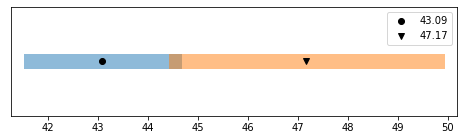

In [101]:
plot_ci(fpar,pcov,fpar2,pcov2)

In [90]:
# se solapan!

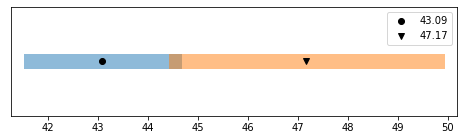

In [113]:
muestra='347-M02'
compare(exp,exp2,muestra)

### Bootstrap resampling


- Let $X$ denote your training dataset. Let $n$ denote the number of samples in your training data. Let $k$ denote the number of resampling iterations you want to perform. The more the better, but k should probably be no fewer than 1000.

- for $i=1,2,…k$ take a random sample $X_i$ (with replacement) of size $n$ from $X$. Train your model and calculate your model paramters. Let $\mu_i$ denote your fitted parameters trained on the ith resampled data set.

- You can now calculate confidence intervals by determining the quantiles of $\hat{\mu} =[ \mu_0,\mu_1,\mu_2,...\mu_k]$ 

For example, to obtain a 95% confidence interval, calculate the 2.5% and 97.5% quantiles of $\hat{\mu}$.

    [1]Reference: Chapters seven and eight of 'The Elements of Statistical Learning'
    
La funcion es:    
    
```
    mu(f,bo_eff,dzucorrnorm,dpatron,sigma, name)
```

Podemos ajustar mu bootstrapeando dzcorrnorm

In [132]:
muestra='347-M02'
repeticion=1
indice_muestra=exp.info[exp.info.muestras == muestra].index.values[0]
df_muestra=exp.data[indice_muestra]
df_repeticion=df_muestra[df_muestra.repeticion == repeticion]
zu=df_repeticion.real + 1j*df_repeticion.imag

In [135]:
df_repeticion

,indice,repeticion,f,real,imag
0,1,1,100.0000,14.98421,0.263184
1,2,1,125.8925,14.98221,0.330962
2,3,1,158.4893,14.98195,0.421990
3,4,1,199.5262,14.98459,0.528198
4,5,1,251.1886,14.98319,0.665497
5,6,1,316.2278,14.97979,0.832728
6,7,1,398.1072,14.98348,1.047533
7,8,1,501.1872,14.98945,1.324106
8,9,1,630.9573,14.98416,1.658915
9,10,1,794.3282,14.98942,2.084738


In [133]:
zu

0     14.984210+0.263184j
1     14.982210+0.330962j
2     14.981950+0.421990j
3     14.984590+0.528198j
4     14.983190+0.665497j
5     14.979790+0.832728j
6     14.983480+1.047533j
7     14.989450+1.324106j
8     14.984160+1.658915j
9     14.989420+2.084738j
10    14.993860+2.629270j
11    14.997470+3.301668j
12    15.015690+4.155917j
13    15.022190+5.224553j
14    15.042430+6.569842j
15    15.077400+8.269302j
16     15.11191+10.40971j
17     15.16944+13.08410j
18     15.23983+16.43334j
19     15.32879+20.61215j
20     15.47045+25.93521j
21     15.68563+32.43575j
22     15.93701+40.79596j
23     16.24729+51.26046j
24     16.80506+64.26440j
25     17.47526+80.57408j
26    18.60037+101.19080j
27    19.46471+126.28340j
28    21.14305+158.20470j
29    23.84257+197.82590j
30    27.0087+0248.07020j
31    31.81373+310.46480j
32    37.00668+387.60840j
33    43.67616+487.42750j
34    53.75298+608.98180j
35    65.75455+764.94780j
36    81.04197+961.64500j
37    104.4554+1214.1260j
38    140.93

In [128]:
def stats_dict(exp):
    ''' excluyendo la primer repeticion para cada muestra devuelve lista de valores medios por f y sus desvios'''
    data_mean={}
    data_std={}
    data_test={}

    for m,datamuestra_m in enumerate(exp.data):
        #excluimos la primer repeticion
        filename=datamuestra_m.filename
        name=exp.info[exp.info.archivo==filename].muestras.values[0]

        df=datamuestra_m[datamuestra_m.repeticion != 1 ]
        #separamos de manera aleatoria un valor de impedancia para cada frecuencia
        df_test=df.groupby('f').sample(1)

        #boramos del dataset original esos valores
        df.loc[df_test.index,'imag']=np.nan
        #calculamos mean y std 
        
        real_mean=df.groupby('f')['real'].mean().values
        imag_mean=df.groupby('f')['imag'].mean().values
        real_std=df.groupby('f')['real'].std().values
        imag_std=df.groupby('f')['imag'].std().values

        data_mean[name]=real_mean+1j*imag_mean
        data_std[name]=real_std+1j*imag_std
        data_test[name]=df_test

    return data_mean,data_std,data_test



def corrnorm(exp,muestra,repeticion):
    data_mean,data_std,data_test=stats_dict(exp)
    w=np.pi*2*exp.f
    z0=exp.bobina['R0']+1j*w*exp.bobina['L0']
    x0=w*exp.bobina['L0']  
    try:
        # correccion muestras
        za=data_mean['aire']
        indice_muestra=exp.info[exp.info.muestras == muestra].index.values[0]
        df_muestra=exp.data[indice_muestra]
        df_repeticion=df_muestra[df_muestra.repeticion == repeticion]
        zu_serie=df_repeticion.real + 1j*df_repeticion.imag
        zu=zu_serie.values
        dzucorr=((1/(1/zu - 1/za+ 1/z0))-z0  )
        dzucorrnorm=dzucorr/x0
        return dzucorrnorm
    except Exception as e:
        print(e)

In [129]:
corrnorm(exp,muestra,repeticion)

array([0.08821518+0.1080525j , 0.06501005+0.10775642j,
       0.05278681+0.12134899j, 0.04497553+0.10618111j,
       0.03497175+0.11042575j, 0.02374018+0.10543388j,
       0.0223735 +0.10431337j, 0.0208782 +0.10928673j,
       0.01653305+0.10430598j, 0.01466008+0.1031013j ,
       0.01305303+0.10490113j, 0.01124603+0.10237611j,
       0.0131193 +0.1022187j , 0.01120937+0.10086236j,
       0.01157768+0.09963786j, 0.01208336+0.09877419j,
       0.0131804 +0.10095463j, 0.01449669+0.1002197j ,
       0.015631  +0.097735j  , 0.01648223+0.09435552j,
       0.01843763+0.09495397j, 0.02170925+0.08721374j,
       0.02328431+0.08679895j, 0.0247591 +0.08502873j,
       0.02804322+0.08012445j, 0.030554  +0.07602441j,
       0.03580014+0.07363389j, 0.0344243 +0.06308254j,
       0.03749977+0.05872075j, 0.04188916+0.05025619j,
       0.04416405+0.04558927j, 0.04784871+0.03962096j,
       0.04880435+0.02980352j, 0.04826382+0.02645345j,
       0.05083684+0.01638943j, 0.05013195+0.00964857j,
       0.0

In [130]:
f2=exp2.f
bo_eff2=exp2.coil
i=2
dpatron2=exp2.info.espesor[i]
sigma2=exp2.info.conductividad[i]
name2=exp2.info.muestras[i]
dzucorrnorm2=corrnorm(exp2,muestra,repeticion)
fpar2, pcov2=fitmu(f2,bo_eff2,dzucorrnorm2,dpatron2,sigma2,name2)
fpar2

array([0.80188856])

In [144]:
muestra

'347-M02'

In [145]:
muestra='1010-M01'
for r in range(1,11):
    i=exp.info[exp.info.muestras == muestra].index.values[0]
    repeticion=r
    f=exp.f
    bo_eff=exp.coil
    dpatron=exp.info.espesor[i]
    sigma=exp.info.conductividad[i]
    name=exp.info.muestras[i]
    dzucorrnorm=corrnorm(exp,muestra,repeticion)
    fpar, pcov=fitmu(f,bo_eff,dzucorrnorm,dpatron,sigma,name)
    print(r,fpar[0])

1 148.99370280277202
2 147.18166464694957
3 148.15320449229142
4 144.53230890000913
5 146.75749853846258
6 145.4611322316285
7 149.47879126746352
8 146.64438553273877
9 149.99300775518967
10 149.32573372612148


In [142]:
exp.info

,archivo,conductividad,espesor,bobina,muestras,mueff,R2
0,Exp_m1_347-M02.csv,1118491.27,0.02340,m1,347-M02,43.092366,0.985982
1,Exp_m1_1010-M01_m1.csv,3830000.00,0.06500,m1,1010-M01,65.490860,0.983339
2,Exp_m1_aire.csv,0.00,0.00000,m1,aire,NaN,NaN
3,Exp_m1_P057.csv,3948000.00,0.14957,m1,P057,NaN,NaN



### Montecarlo

https://cran.r-project.org/web/packages/nlraa/vignettes/Confidence-Bands.html

## otros

https://stat.ethz.ch/~stahel/courses/cheming/nlreg10E.pdf
